In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 
# dt as time_series operation
%matplotlib inline
# for display dataframe
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
# ignore warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# storage
from google.datalab import Context
import google.datalab.bigquery as bq
try:
  from StringIO import StringIO
except ImportError:
  from io import BytesIO as StringIO
# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb

In [2]:
# square scale
import matplotlib.scale as mscale
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
import numpy as np

class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """

    name = 'squareroot'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax

    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a): 
            return np.array(a)**0.5

        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()

    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return np.array(a)**2

        def inverted(self):
            return SquareRootScale.SquareRootTransform()

    def get_transform(self):
        return self.SquareRootTransform()

mscale.register_scale(SquareRootScale)
'''
fig, ax = plt.subplots(1)

ax.plot(np.arange(0, 9)**2, label='$y=x^2$')
ax.legend()

ax.set_yscale('squareroot')
ax.set_yticks(np.arange(0,9,2)**2)
ax.set_yticks(np.arange(0,8.5,0.5)**2, minor=True)

plt.show()
''';

# IO

In [3]:
%gcs read --object gs://kk_data/ft_satisfaction.csv -v df_ft_satis

In [ ]:
%gcs read --object gs://kk_data/ft_day_listen.csv -v df_ft_day_listen

In [4]:
df_ft_satis = pd.read_csv(StringIO(df_ft_satis))

In [5]:
df_ft_satis = pd.read_csv(StringIO(df_ft_satis))
df_ft_day_listen = pd.read_csv(StringIO(df_ft_day_listen))
df_train = pd.merge(df_ft_day_listen, df_ft_satis, how='left',on=['msno'])

In [9]:
%gcs read --object gs://kk_data/sub_ft_satisfaction.csv -v df_sub_ft_satis

In [10]:
%gcs read --object gs://kk_data/sub_ft_day_listen.csv -v df_sub_ft_day_listen

In [11]:
df_sub_ft_day_listen = pd.read_csv(StringIO(df_sub_ft_day_listen))
df_sub_ft_satis = pd.read_csv(StringIO(df_sub_ft_satis))
df_sub = pd.merge(df_sub_ft_day_listen, df_sub_ft_satis, how='left',on=['msno'])

In [13]:
df_sub.is_churn = np.nan

In [15]:
%gcs read --object gs://kk_data/members_v3.csv -v members

In [16]:
df_members =pd.read_csv(StringIO(members))

In [23]:
df_data = df_train.append(df_sub)
df_data = pd.merge(df_data, df_members, how='left',on=['msno'])
gender_encode = {'male':1, 'female':2}
df_data.gender = df_data.gender.map(gender_encode)
# missing value 
print('-'*10,'missing value summary','-'*10)
df_data.isnull().sum() / len(df_data)

---------- missing value summary ----------


msno                        0.000000
is_churn                    0.505845
day_listen                  0.186747
user_latent_satisfaction    0.186747
city                        0.123263
bd                          0.123263
gender                      0.645911
registered_via              0.123263
registration_init_time      0.123263
dtype: float64

# registered_via

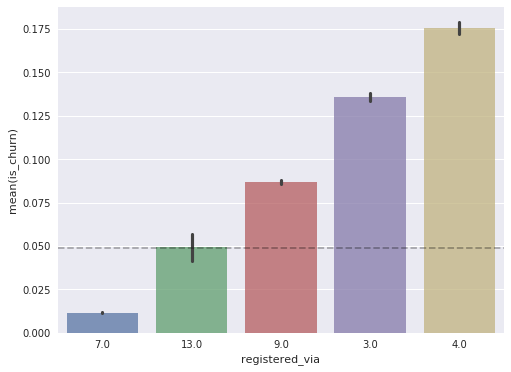

In [41]:
# aggregate result in order to sort 
result_reg = df_data.groupby(["registered_via"])['is_churn'].mean().reset_index().sort_values('is_churn')
# make plot
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='registered_via',y='is_churn',data=df_data,order=result_reg['registered_via'],ax=ax,alpha=.75)
ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)

In [56]:
df_data.registered_via = df_data.registered_via.fillna(-1)
df_data.day_listen = df_data.day_listen.fillna(-1)
df_data.user_latent_satisfaction = df_data.user_latent_satisfaction.fillna(-1)

## Modeling

In [57]:
def model_training_rf(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
  # Training ~ 01:45s
  model = RandomForestClassifier(random_state=2,n_estimators=300,
                           min_samples_split=0.05,n_jobs=-1,class_weight={0 :0.45,1 :0.55})
  model.fit(X_train,Y_train)
  
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission

In [54]:
df_train, df_sub = df_data[:len(df_train)], df_data[len(df_train):]
print(df_train.columns)
print(df_sub.columns)
reg_via_fts = ['msno','is_churn','day_listen','user_latent_satisfaction','registered_via']

Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time'],
      dtype='object')
Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time'],
      dtype='object')


In [58]:
reg_via_model, reg_via_val_score,\
reg_via_pred = model_training_rf(df_train[reg_via_fts],df_sub[reg_via_fts])

In [74]:
print('day_listen + user_letent_satisfaction logloss val: ',0.192158)
print('reg_via log_loss val: ',np.around(reg_via_val_score,decimals=6))
print('-'*20,'LB','-'*20)

day_listen + user_letent_satisfaction logloss val:  0.192158
reg_via log_loss val:  0.167227
-------------------- LB --------------------


Text(0.5,0,'Relative Importance')

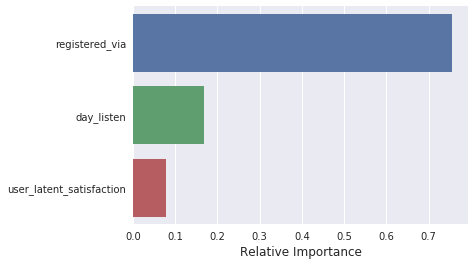

In [69]:
# importance --> index --> sort
indices = np.argsort(reg_via_model.feature_importances_)[::-1]
# plot
g = sns.barplot(y = df_train[reg_via_fts].drop(labels=['msno','is_churn'],axis=1).columns[indices], 
                x = reg_via_model.feature_importances_[indices],
               orient='h')
g.set_xlabel("Relative Importance", fontsize = 12)
# g.set_ylabel("Features", fontsize = 12)
# reg_via_model.feature_importances_

In [59]:
print(reg_via_val_score)
df_train[reg_via_fts].drop(labels=['msno',is_churn])

0.16722727152951256

## RF feature importance